In [25]:
import sys
sys.path.append('../')

import numpy as np
from scipy import ndimage

from skimage.filters import sobel_h
from skimage.filters import sobel_v
from scipy import stats


import os
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.proj3d import proj_transform
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d


import scienceplots
from tensorflow.python.client import device_lib

#plt.rcParams['figure.figsize'] = [10,10]

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import decode_predictions
from tensorflow.keras.applications import VGG16

from tensorflow.nn import depthwise_conv2d
from tensorflow.math import multiply, reduce_sum, reduce_mean,reduce_euclidean_norm, sin, cos, abs
from tensorflow import stack, concat, expand_dims

import tensorflow_probability as tfp

from utils.utils import *
import cv2

from scipy import ndimage, fft
from io import BytesIO

plt.style.use(['science', 'ieee'])
plt.rcParams.update({'figure.dpi': '100'})

In [26]:
k = 3   # kernel size
beta2s = [1, 0, 0.25, 0.5, 0.75] #[0, 0.25, 0.75, 1]  
activations = [tf.nn.relu]
timestamps = [1,5,10]
experiment_name = "unipolar_single_pixel"
box_dims = [20, 16]
step =   4 # Plot axis step

In [27]:
tf.nn.relu.__name__

'relu'

In [28]:
# Single pixel input

img = np.zeros((115,115)) # cv2.imread('input4.png', 0)/255. 
mid = img.shape[0]//2
img[mid, mid] = 1.
print(img.shape)

(115, 115)


In [29]:
filters = np.zeros((3,3,1,1))
img = tf.cast(tf.repeat(tf.expand_dims([img], axis=-1) , repeats = filters.shape[-2], axis=-1), dtype=tf.float32) 


8 -8
1 1
4.0 0.0


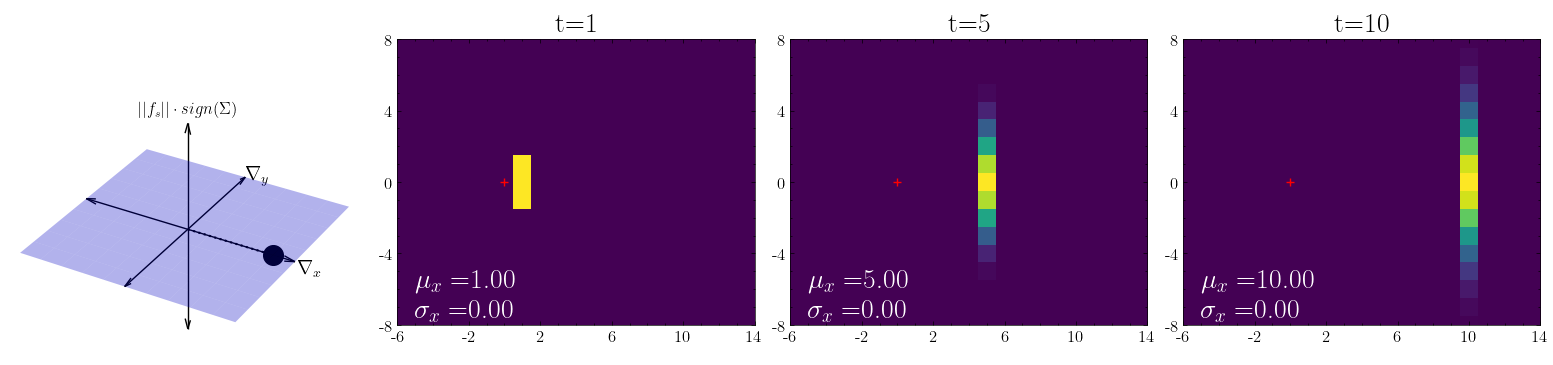

0.0 4.0


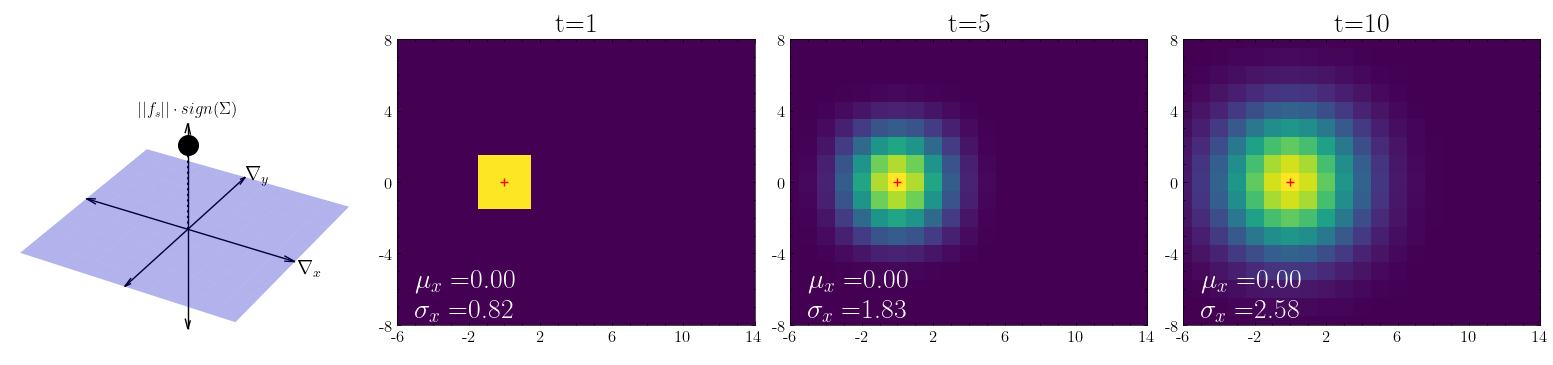

2.0 3.4641016151377544


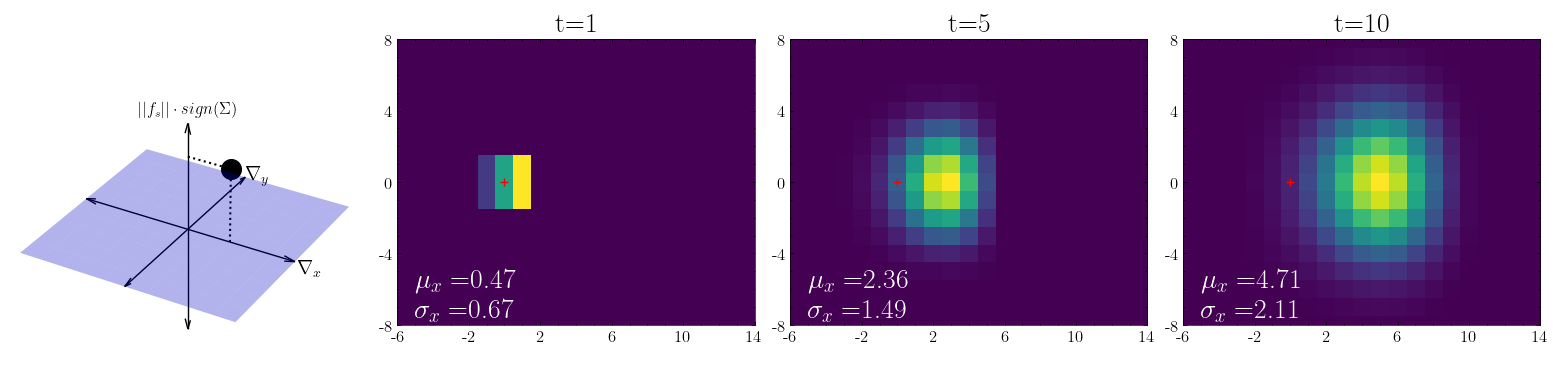

2.8284271247461903 2.8284271247461903


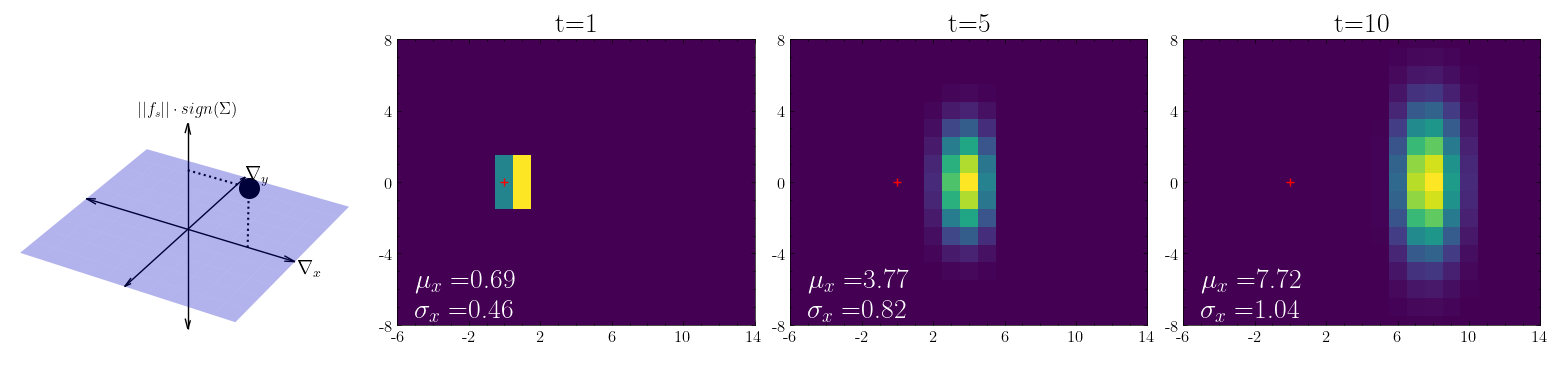

3.4641016151377544 2.0


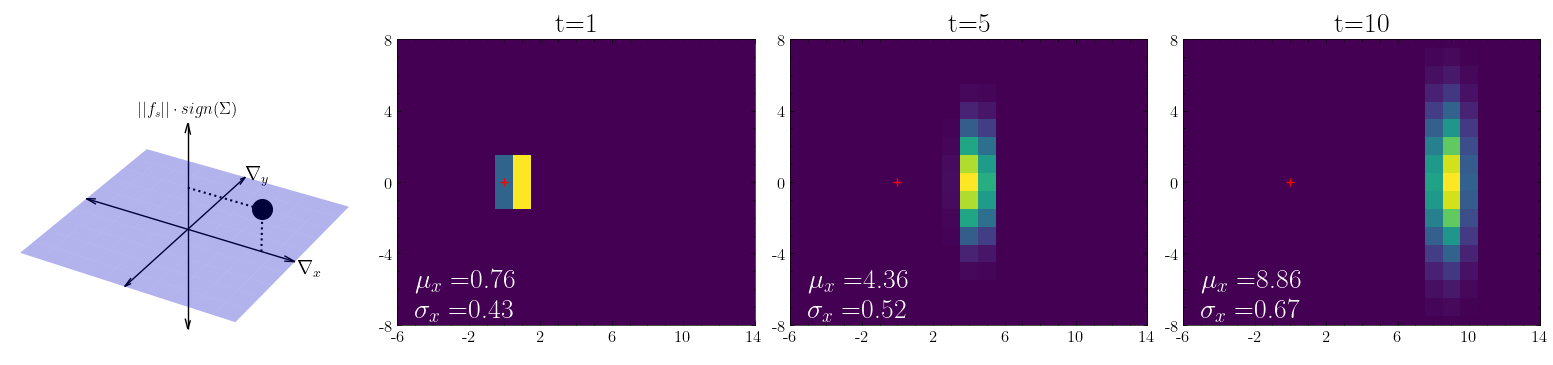

In [30]:
import matplotlib.patches as mpatches



filters = np.zeros((3,3,1,1))
x = tf.cast(tf.repeat(tf.expand_dims([img], axis=-1) , repeats = filters.shape[-2], axis=-1), dtype=tf.float32) 



#Get image height and width

vals_x = img[0, img.shape[1]//2, :, :]
vals_y = img[0, :, img.shape[2]//2, :]
nonzeros = np.nonzero(vals_x)[0]
if nonzeros.size > 0:
    length_y = nonzeros[-1] - nonzeros[0] + 1
else:
    length_y = 0  # all zeros
nonzeros = np.nonzero(vals_x)[0]
if nonzeros.size > 0:
    length_x = nonzeros[-1] - nonzeros[0] + 1
else:
    length_x = 0  # all zeros



#step = 2**np.floor(np.log2(( (length_x) + np.max(timestamps) )// 5))


max_x = int(box_dims[0]*(.7))
min_x = -int(box_dims[0]*(.3))

max_y = box_dims[1]//2
min_y = -(box_dims[1]//2)

print(max_y, min_y)
print(length_x, length_y)


for activation in activations:
	for beta2 in beta2s:

		
		images = []

		filters = np.zeros((3,3,1,1))

		t = np.zeros((3,3))
		t[1, 0] = np.sqrt(beta2)
		t[0, 0] = np.sqrt(1-beta2)
		filters = np.reshape(fft.idctn(t, norm='ortho'), (3,3,1,1)) 
		#filters /= np.sum(np.abs(filters))
		
		w =tf.cast(filters, dtype=tf.float32)# tf.expand_dims(filters, -1), dtype=tf.float32)
		w = tf.transpose(w, perm=(1,0,2,3))


		x = img


		directory = f"figures/{experiment_name}_{activation.__name__}_{k}x{k}_{beta2}"
		if not os.path.exists(directory):
			os.makedirs(directory)




		#Generate Plot
		fig = plt.figure(figsize=(16,len(timestamps)+1))
		gs = fig.add_gridspec(1,len(timestamps)+1, wspace=0.1)

		ax0 = fig.add_subplot(gs[0], projection='3d')
		plot_filter_x(beta2, ax = ax0)
		ax0.axis('off')

		#for i, im in enumerate(images):	
		plot_num = 1
		for i in range(timestamps[-1]+1):
			x = x/np.std(x)

			if i in timestamps:

				ax = fig.add_subplot(gs[plot_num])
				plot_num+=1

				vals = x[0, x.shape[1]//2, :, :]
				vals = vals/np.sum(vals)

				pos = np.expand_dims(np.linspace(-(x.shape[1]//2), x.shape[1]//2, x.shape[1]),-1)
				mean = tf.reduce_sum(pos*vals)
				var = tf.reduce_sum(((pos-mean)**2) * vals)
				std = np.sqrt(var)
				#print(mean, np.sqrt(var))
				
				im = ax.imshow(np.sum(x[0,:,:,:], axis=-1))
				ax.plot(mid, mid, marker = '+', color='red')

				'''arr =  mpatches.FancyArrowPatch((mid, mid), (mid+mean+std, mid),
										mutation_scale=4, shrinkA=0, shrinkB=0,zorder=10, color="red")
				ax.add_patch(arr)'''


				ax.annotate(r'$\sigma_x=$'+f"{std:.2f}", (0.05,0.01), ha='left', va='bottom',color='white', xycoords='axes fraction', fontsize=20)
				ax.annotate(r'$\mu_x=$'+f"{mean:.2f}", (0.05,0.11), ha='left', va='bottom',color='white', xycoords='axes fraction', fontsize=20)
				#ax.annotate(r'$argmax_x=$'+f"{np.argmax(vals)-mid:.2f}", (0.05,.17), ha='left', va='bottom',color='white', xycoords='axes fraction')
				
				#ax.annotate(r'$\sigma=$'+f"{std:.2f}", (.5, 6), xycoords=arr, ha='center', va='bottom',color='white')
				#ax.arrow(, 112, dx=, dy= 0, color='black')




				ax.set(xlim=((mid + min_x, mid+max_x)) , ylim=((mid+min_y, (mid+max_y))))

				# Re-label ticks relative to midpoint
				xticks = ax.get_xticks()
				yticks = ax.get_yticks()

				#ax.set_xticklabels(np.arange(min_x, max_x+1, step=2))
				#ax.set_yticklabels(np.arange(min_y, max_y+1, step=2))
				xticks = np.arange(np.sign(min_x) * (np.abs(min_x)//2)*2, step+(max_x//2)*2, step=step) + mid
				yticks = np.arange(np.sign(min_y) * (np.abs(min_y)//2)*2, step+(max_y//2)*2, step=step) + mid
				ax.set_xticks(xticks)
				ax.set_yticks(yticks)
				ax.tick_params(axis='x', labelsize=12)
				ax.tick_params(axis='y', labelsize=12)


				ax.set_xticklabels([x - mid for x in xticks])
				ax.set_yticklabels([y - mid for y in yticks])



				#ax.set_xticks(np.linspace(-round(std)-1, round(std)+1, int(0.5*(std)+3)))
				#fig.colorbar(im, orientation='vertical')

				'''plt.close(fig) 
				buf = BytesIO()
				fig.savefig(buf, format="svg", dpi=fig.dpi, bbox_inches="tight")
				buf.seek(0)'''



				#ax0.imshow(im)
				#ax.axis('off')
				ax.set_title(f"t={i}", fontsize=20)


				#images.append(Image.open(buf))

			x = activation( tf.nn.conv2d(x, w , strides=(1,1), 
									padding='SAME') )
		


		fig.subplots_adjust(left=0.02, right=0.98, top=0.9, bottom=0.01, wspace=0.1)
		fig.savefig(f"{experiment_name}_{k}x{k}__{activation.__name__}_{beta2}.pdf", format="pdf", dpi=fig.dpi, bbox_inches="tight")
		plt.show()


In [31]:
i

10

In [32]:
step

4